# Hands-On Optimization in Deep Learning @ MATH+ Summer School
Welcome to the Math+ summer school session on optimization in deep learning! In this notebook, we'll explore different optimization algorithms and their impact on training neural networks.

In [3]:
# Setup: Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split


## Data Preprocessing

Before we train our model, let's load and preprocess the MNIST dataset.


In [4]:
# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transform data to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
dataset = MNIST(root='./data', download=True, transform=transform)

# Split the dataset into training, validation, and test sets
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Training Samples: {len(train_set)}")
print(f"Validation Samples: {len(val_set)}")
print(f"Testing Samples: {len(test_set)}")


100%|██████████| 9912422/9912422 [00:00<00:00, 50808040.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21600516.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18321067.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6745937.95it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training Samples: 50000
Validation Samples: 10000
Testing Samples: 10000


## Neural Network Model

Now, let's define a simple feed-forward neural network to serve as our baseline model. 


In [5]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Create an instance of the model and move it to the device
model = SimpleNN().to(device)
print(model)


SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Training the Model

Let's first define our training and evaluation functions.


In [6]:
# Define the loss and metrics
criterion = nn.CrossEntropyLoss()

# Define the training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

# Define the evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    accuracy = correct_predictions / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), accuracy


## Training with SGD


In [7]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 10

# Initialize model and optimizer
model_sgd = SimpleNN().to(device)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate)

# Train model
train_loss_sgd = []
val_loss_sgd = []
for epoch in range(num_epochs):
    loss = train_model(model_sgd, train_loader, optimizer_sgd, criterion, device)
    train_loss_sgd.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_sgd, val_loader, criterion, device)
    val_loss_sgd.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Training Loss: 2.0536, Validation Loss: 1.8737, Validation Accuracy: 0.6361
Epoch 2/10, Training Loss: 1.8075, Validation Loss: 1.7629, Validation Accuracy: 0.7265
Epoch 3/10, Training Loss: 1.7439, Validation Loss: 1.7410, Validation Accuracy: 0.7366
Epoch 4/10, Training Loss: 1.7288, Validation Loss: 1.7301, Validation Accuracy: 0.7424
Epoch 5/10, Training Loss: 1.7019, Validation Loss: 1.6692, Validation Accuracy: 0.8178
Epoch 6/10, Training Loss: 1.6521, Validation Loss: 1.6496, Validation Accuracy: 0.8288
Epoch 7/10, Training Loss: 1.6398, Validation Loss: 1.6427, Validation Accuracy: 0.8316
Epoch 8/10, Training Loss: 1.6337, Validation Loss: 1.6369, Validation Accuracy: 0.8365
Epoch 9/10, Training Loss: 1.6298, Validation Loss: 1.6343, Validation Accuracy: 0.8379
Epoch 10/10, Training Loss: 1.6266, Validation Loss: 1.6305, Validation Accuracy: 0.8402


## Training with Adam


In [9]:
# Set hyperparameters
learning_rate = 0.001

# Initialize model and optimizer
model_adam = SimpleNN().to(device)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=learning_rate)

# Train model
train_loss_adam = []
val_loss_adam = []
for epoch in range(num_epochs):
    loss = train_model(model_adam, train_loader, optimizer_adam, criterion, device)
    train_loss_adam.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_adam, val_loader, criterion, device)
    val_loss_adam.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Training Loss: 1.6159, Validation Loss: 1.5466, Validation Accuracy: 0.9198
Epoch 2/10, Training Loss: 1.5450, Validation Loss: 1.5381, Validation Accuracy: 0.9267
Epoch 3/10, Training Loss: 1.5281, Validation Loss: 1.5226, Validation Accuracy: 0.9397
Epoch 4/10, Training Loss: 1.5177, Validation Loss: 1.5102, Validation Accuracy: 0.9527
Epoch 5/10, Training Loss: 1.5097, Validation Loss: 1.5141, Validation Accuracy: 0.9481
Epoch 6/10, Training Loss: 1.5056, Validation Loss: 1.5034, Validation Accuracy: 0.9599
Epoch 7/10, Training Loss: 1.5025, Validation Loss: 1.5111, Validation Accuracy: 0.9521
Epoch 8/10, Training Loss: 1.4997, Validation Loss: 1.5040, Validation Accuracy: 0.9575
Epoch 9/10, Training Loss: 1.4961, Validation Loss: 1.5009, Validation Accuracy: 0.9615
Epoch 10/10, Training Loss: 1.4944, Validation Loss: 1.4984, Validation Accuracy: 0.9638


## Comparing Results


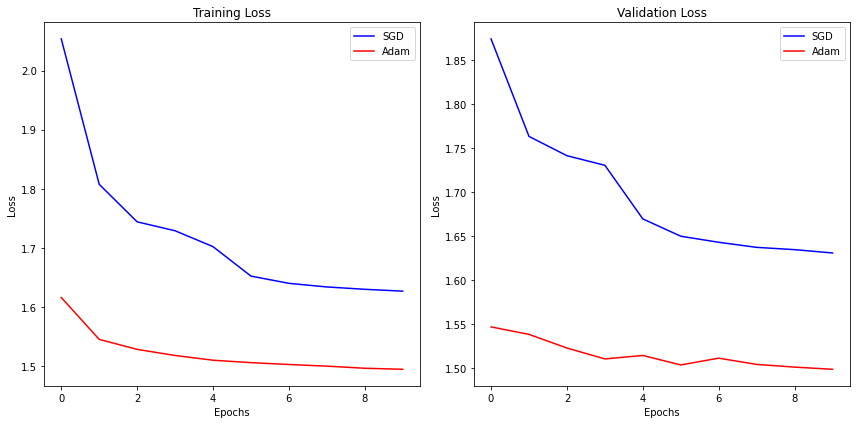

In [11]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="SGD", color='blue')
plt.plot(train_loss_adam, label="Adam", color='red')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="SGD", color='blue')
plt.plot(val_loss_adam, label="Adam", color='red')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
